# IR Search Engine

Andrzej Kajdasz 148273 <br>
Bartosz Stachowiak 148259
<hr>

In [1]:
import pandas as pd

import search
import visualize

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 1. Geting data

### Scraping and preprocesing

To download articles, start with the **scrape.py** script.
It works as follows:
-   After giving the initial page, we get the desired number of links. Searching for these links is based on the BFS method, thanks to which our articles are related to each other, which will allow us to better analyze the operation of the rest of the program (Ordering is consistent since we do not shuffle the found links). It is also worth mentioning the prevention of duplicate links (wikipedia very often suggests to look from page A to page B and from page B to page A)
     -    if we do not specify the start page, we will get the desired number of links selected randomly based on a special Wikipedia link (a convenient solution but we cannot control what pages we get, which prevents consistency in random case)
-    Next step is fetching all links
-    Then text from each article is preprocesed:
     -    lemmatized
     -    converted to small letters
     -    filtered out of stopwords
-    Last step is exporting articles to file. There is two options - csv or parquet.

In [2]:
docs_df = pd.read_parquet("related_large_set_den.pq")
texts = docs_df.text.tolist()
texts = [text.replace(";", " ") for text in texts]

print("Docs dataframe shape:", docs_df.shape)
docs_df.head()

Docs dataframe shape: (1999, 3)


,title,url,text
0,Denmark,https://en.wikipedia.org/wiki/Denmark,coordinates;europe;green;dark;grey;european;un...
1,Withdrawal of Greenland from the European Comm...,https://en.wikipedia.org/wiki/Withdrawal_of_Gr...,part;european;communities;ec;twelve;year;green...
2,Rigshospitalet,https://en.wikipedia.org/wiki/Rigshospitalet,rigshospitalet;meaning;national;state;hospital...
3,Robert Jacobsen,https://en.wikipedia.org/wiki/Robert_Jacobsen,robert;julius;tommy;jacobsen;june;january;dani...
4,Gudenå,https://en.wikipedia.org/wiki/Guden%C3%A5,pronounced;denmark;longest;river;run;central;p...


Stored dataframes consist of the title, url and tokenized and preprocessed text separated by semicolons.
The set originating from Denmark article has 1999 documents (when fetching the data one link has failed).

### Analysis of preprocessed

We can analyze our data, i.e. Wikipedia pages after preprocessing. This will allow us to evaluate later how searches for similar articles work.

In the case described below, the base article, i.e. the one from which we started BFS, is https://en.wikipedia.org/wiki/Denmark.

In [3]:
visualize_df = docs_df.copy(deep = True)
visualize_df.text = texts

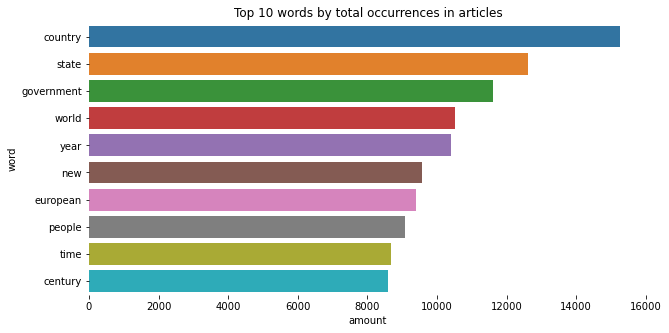

In [4]:
visualize.visualize_most_frequent(visualize_df, 10)

Plot above shows ten words with the most occurrences in the text. We can see the words that follow directly from the initial article we chose- government and country. Words such as world or people are also not surprising. 

A large number of words such as century, year or time may suggest that the BFS method found a large number of articles related to history.

This makes sense since we start from the article describing a country and such articles contain a large section about the country history.

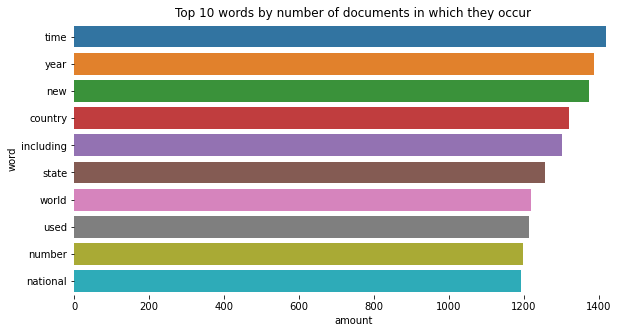

In [5]:
visualize.visualize_most_frequent(visualize_df, 10, method="count")

This plot is presenting words which occur in most articles. You can notice many words that are very universal on the basis of which it is difficult to predict what the article is about - new, used, number, including. However, we have a large group of words related to time, which may suggest a connection with history (time, year) and geopolitics (country, world, national).  

## 2. Similarities

### Creating TFIDF index


The first step before starting to look for similarities between articles is to prepare the tool necessary for this task. 

Simple Search Engine, after receiving texts, vectorizes them at the same time creating tfidf. It is worth mentioning that we can determine the threshold according to which words with the smallest tfidf will not be taken into account.

We will start with threshold equal to 0 and compare the results and shape with engine with index compiled with a high threshold later.

In [6]:
engine = search.SimpleSearchEngine()
engine.compile_index(texts, docs_df.url.tolist())

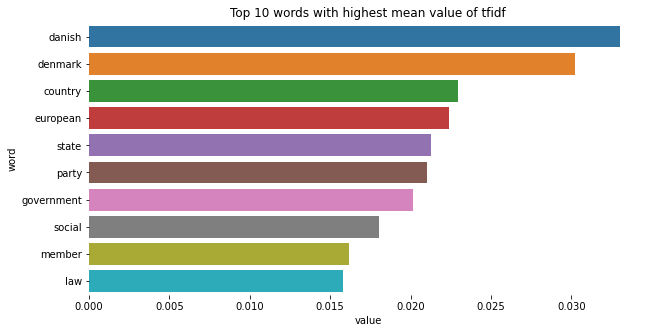

In [7]:
visualize.visualize_tfidf(engine.index, 10)

In plot above we can see ten words with the highest mean value in tfidf. Unlike words before (which were often very general), now we have words that are much more specific and related to a given topic - danish, denmark, european, government, social, law. It is worth noting that, for example, the words "year" and "used" are not in the above-mentioned words, although they were very numerous and appeared in many articles. At the same time, the words "danish" and "denmark" appear to us for the first time. This is extremely important and fully reflects the idea of ​​how tfidf works.

### Single Query Recommendation

When our engine is fully ready, we can provide it with urls to which it should find similar articles.

Similarity counting is based on cosine similarity.

Lets start with a vaguely related topic to the seed article - Scania Regional Council is the regional council of Scania County in Sweden.

We will see the top 3 recomendations and their respective breakdown on the 5 most influential words.

https://en.wikipedia.org/wiki/Scania                 0.489608
https://en.wikipedia.org/wiki/Counties_of_Denmark    0.362108
https://en.wikipedia.org/wiki/Regions_of_Denmark     0.352237
Name: _SCORE_TOTAL, dtype: float64


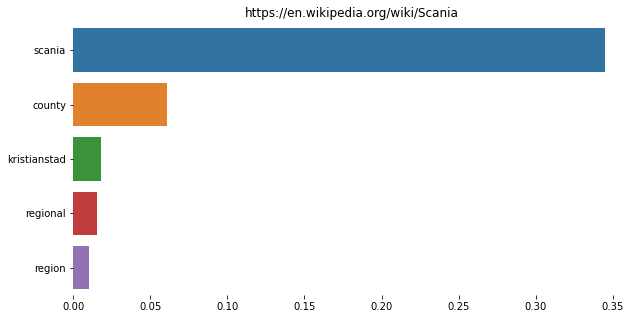

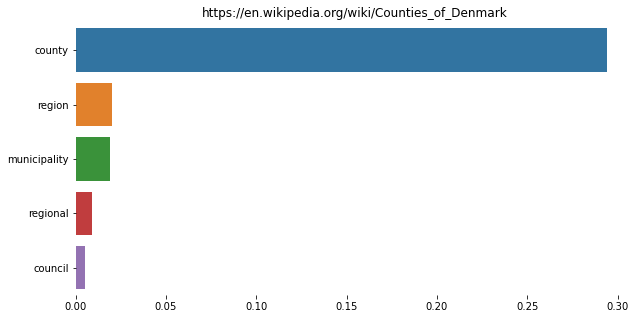

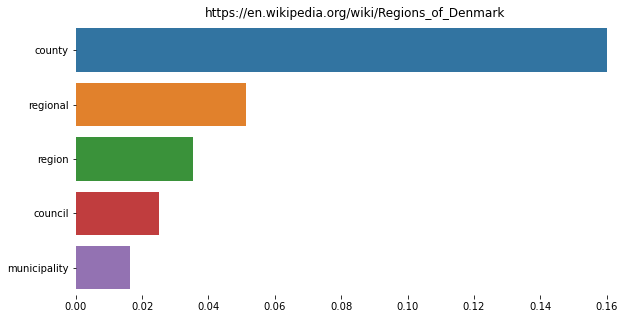

In [8]:
scania_url = "https://en.wikipedia.org/wiki/Scania_Regional_Council"
scania_query = search.wiki_page_from_url_to_content_text(scania_url) 

scania_scores_df = engine.get_scores_dataframe_from_query(scania_query, top_n=3)
print(scania_scores_df.iloc[:, -1])
visualize.visualize_top_scores(scania_scores_df, 5)

### History Recommendation

Our schema for resolving providing a recommendation is quite straightforward (yet effective).
For each query we calculate scores for each of the documents and then return the average of the scores to the user.

The first article is about Scania which is the main city of Scania Regional Council, so the result is very good - we can see that the most important words was "scania" and it is not a suprise. Second and third articles was related to the administrative division of Denmark. It's because our dataset stared in Denmark we don't have probably much pages about Sweden. The most important words are words referring to the administrative division of the country - county, regional, region, council.

Now we'll verify the results for slightly more distant articles - search history consisting of articles with two capitals - Berlin and Moscow.

This time we will fetch top 10 documents with word breakdown for top 10 words.

https://en.wikipedia.org/wiki/Russia                 0.202926
https://en.wikipedia.org/wiki/Germany                0.193364
https://en.wikipedia.org/wiki/S-train                0.187628
https://en.wikipedia.org/wiki/Cold_War               0.159534
https://en.wikipedia.org/wiki/Russian_Empire         0.153937
https://en.wikipedia.org/wiki/Europe                 0.150461
https://en.wikipedia.org/wiki/Copenhagen,_Denmark    0.142852
https://en.wikipedia.org/wiki/Copenhagen             0.142852
https://en.wikipedia.org/wiki/Capital_city           0.135455
https://en.wikipedia.org/wiki/Northern_Germany       0.124440
Name: _SCORE_TOTAL, dtype: float64


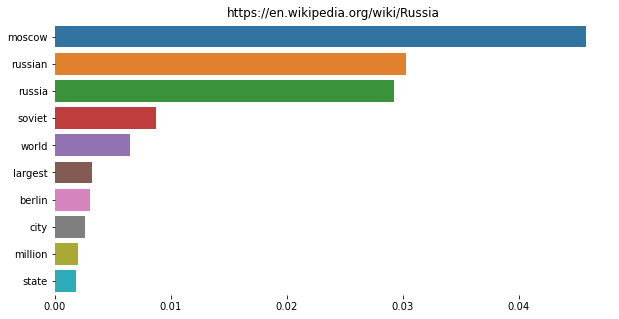

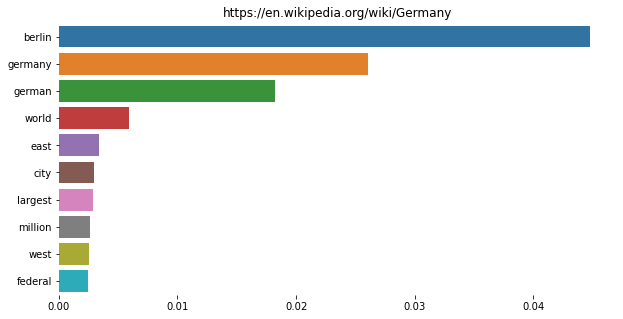

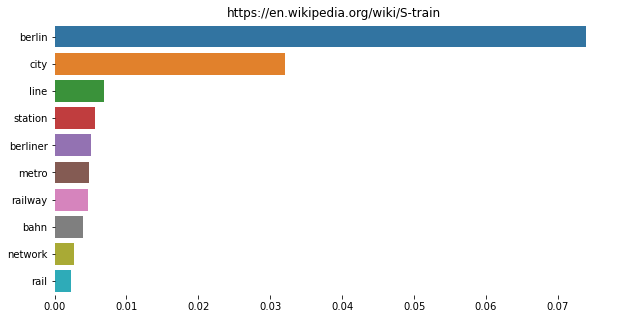

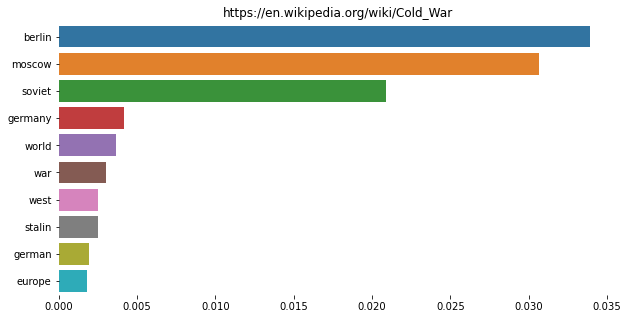

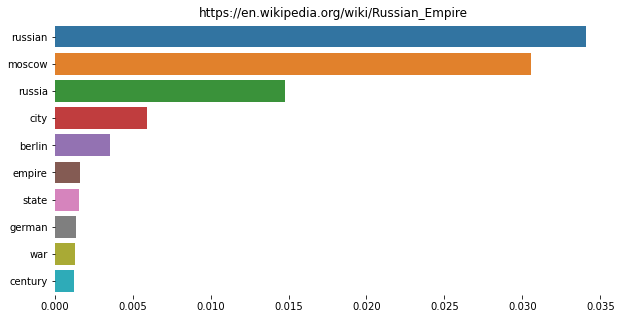

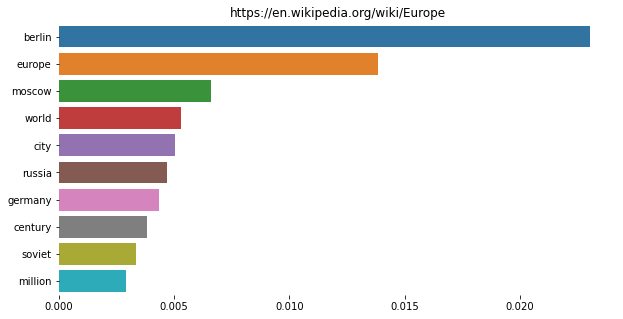

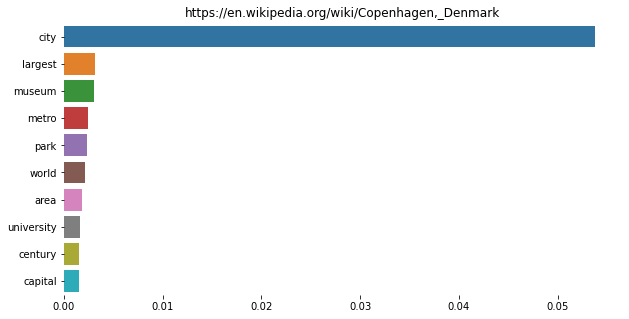

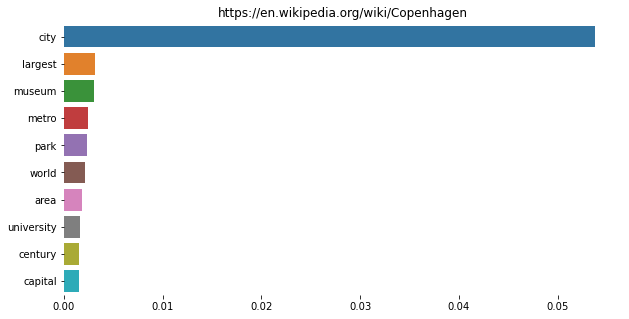

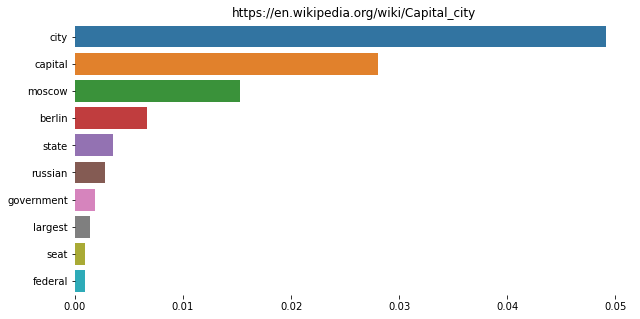

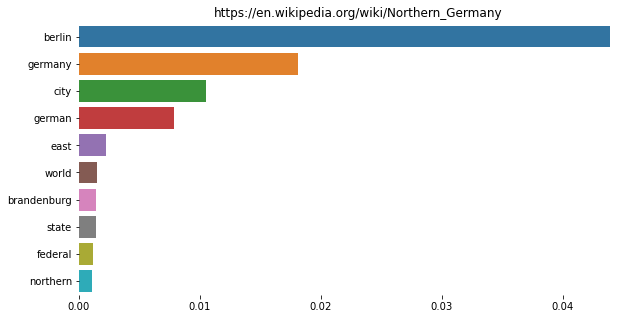

In [9]:
capitals_urls = ["https://en.wikipedia.org/wiki/Berlin", "https://en.wikipedia.org/wiki/Moscow"]
capitals_queries = [search.wiki_page_from_url_to_content_text(url) for url in capitals_urls]

capitals_scores_df = engine.get_scores_dataframe_from_queries(capitals_queries, top_n=10)
print(capitals_scores_df.iloc[:, -1])
visualize.visualize_top_scores(capitals_scores_df, 10)

First two articles are Germany and Russia, both of which do not require much explanation.
We can see that the most important words are just berlin and moscow but also russian, russia and soviet in case of Moscow. In case of Berlin - germany and german.

A big surprise for us may be the third article - S train. However, when we check what this train is, it turns out that it is simply the Berlin subway. 

Therefore, the most important words are "berlin" and "city" and "line" and "station". The following articles can be divided into those that go towards the history of Germany and Russia, where the most important words are related to these countries (german, russia, etc.). 

The second direction is the capital. We have an article about capital cities and Copenhagen, the capital of Denmark. In these cases, the most important word is the city and words related to the infrastructure of cities, such as museum.

We will finish off with something even less related to the source article - kangaroo and penguin

https://en.wikipedia.org/wiki/Australia                   0.081306
https://en.wikipedia.org/wiki/Pinniped                    0.053716
https://en.wikipedia.org/wiki/List_of_birds_of_Denmark    0.049617
https://en.wikipedia.org/wiki/New_Zealand                 0.048699
https://en.wikipedia.org/wiki/Orca                        0.044720
Name: _SCORE_TOTAL, dtype: float64


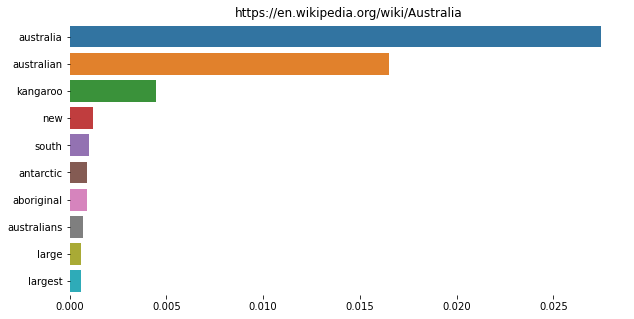

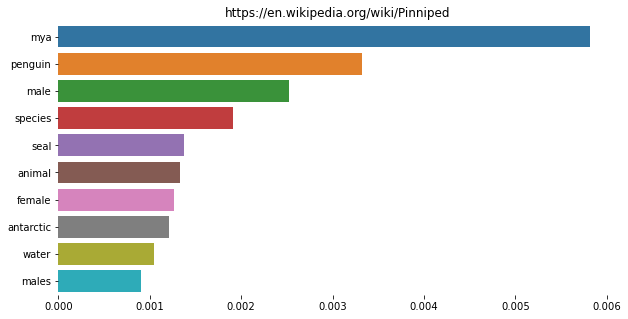

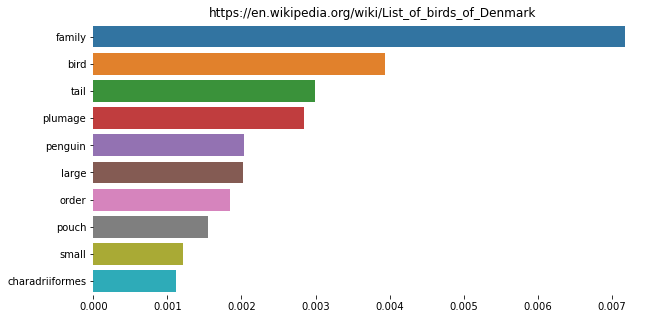

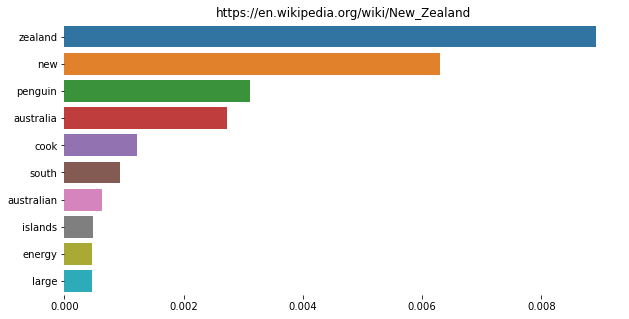

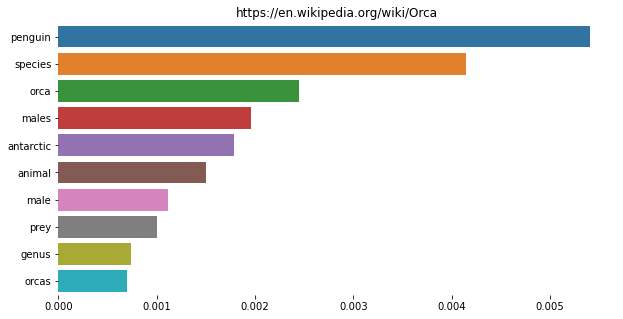

In [10]:
animals_urls = ["https://en.wikipedia.org/wiki/Kangaroo", "https://en.wikipedia.org/wiki/Penguin"]
animals_queries = [search.wiki_page_from_url_to_content_text(url) for url in animals_urls]

animal_scores_df = engine.get_scores_dataframe_from_queries(animals_queries, top_n=5)
print(animal_scores_df.iloc[:, -1])
visualize.visualize_top_scores(animal_scores_df, 10)

Surprisingly, it turns out that even for words from the other side of the globe, we find the perfect article, i.e. Australia and New Zealand. The only places on Earth where both animals occur in the wild.

We also get other animals from those regions of the world and a list of birds from Denmark and an article about global warming. 

Analyzing the individual words that had the most important meaning, it can be seen that most of them come from the article about penguins, this is probably due to the fact that the word penguin appeared in our database and the word kangaroo did not, but nevertheless the most important words from both articles, i.e. "australia" and "zealand".

To finish our demonstration we will check the results for article hisotry consisting of various military commanders from the 1st. half of the XXth century.

https://en.wikipedia.org/wiki/World_War_I                 0.184179
https://en.wikipedia.org/wiki/World_War_II                0.138141
https://en.wikipedia.org/wiki/Romanian_Armed_Forces       0.131758
https://en.wikipedia.org/wiki/Hungarian_Defence_Forces    0.123255
https://en.wikipedia.org/wiki/Commander-in-chief          0.119803
Name: _SCORE_TOTAL, dtype: float64


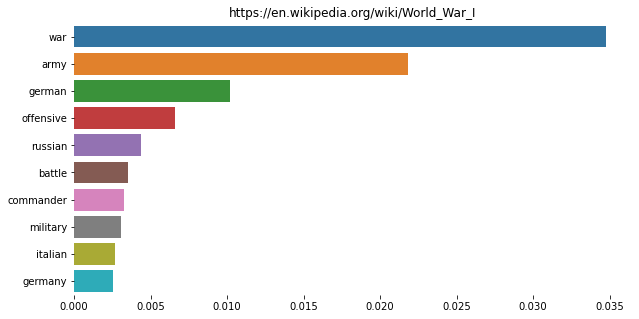

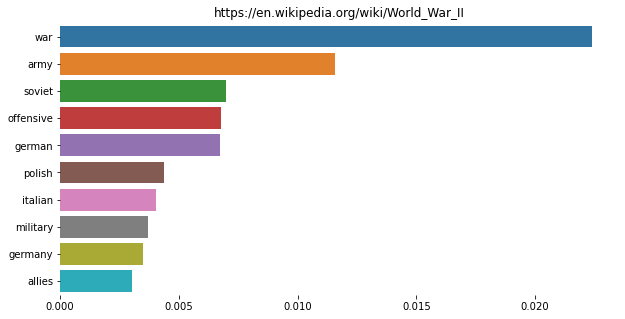

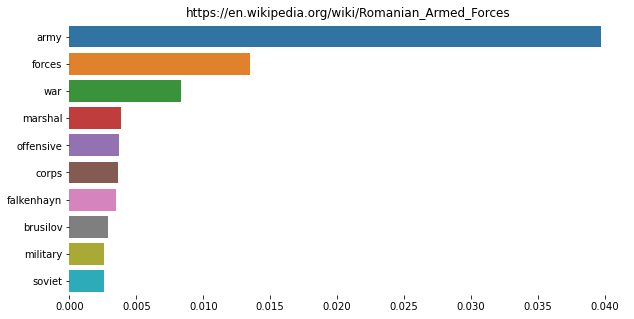

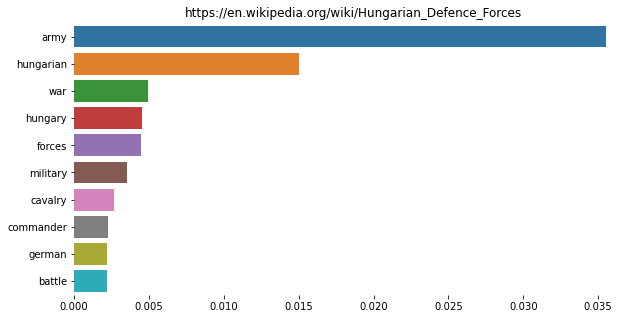

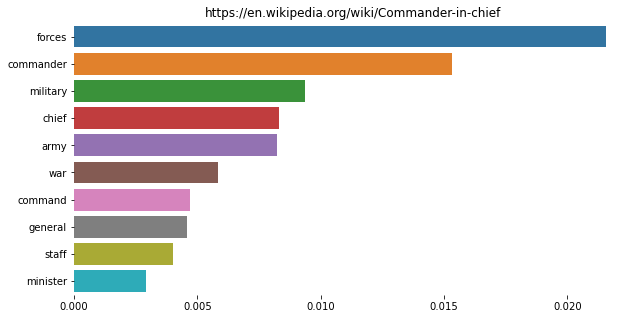

In [11]:
history_urls = [
    "https://en.wikipedia.org/wiki/Erich_von_Falkenhayn", 
    "https://en.wikipedia.org/wiki/Aleksei_Brusilov", 
    "https://en.wikipedia.org/wiki/Rodolfo_Graziani",
    "https://en.wikipedia.org/wiki/Erwin_von_Witzleben",
    "https://en.wikipedia.org/wiki/Juliusz_R%C3%B3mmel",
    "https://en.wikipedia.org/wiki/Franz_Conrad_von_H%C3%B6tzendorf",
    "https://en.wikipedia.org/wiki/Georgy_Zhukov",
    "https://en.wikipedia.org/wiki/Ferdinand_Foch"
]
history_queries = [search.wiki_page_from_url_to_content_text(url) for url in history_urls]

history_scores_df = engine.get_scores_dataframe_from_queries(history_queries, top_n=5)
print(history_scores_df.iloc[:, -1])
visualize.visualize_top_scores(history_scores_df, 10)

And according to our intuition the top recommendations two are WW1 and WW2 (order of which matches the count of WW1 commanders (5 [or 6 if you count Zhukov as WW1 commander (he was an NCO at the time)]) to count of WW2 ones (4)).

## 3. Engine index compilation threshold

Currently we inclue all of the words that occure in our documents and gave passed the preprocessing step.
This unfortunately results in a lot of insignificant tokens cluttering our memory.

In [12]:
engine.index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, https://en.wikipedia.org/wiki/Denmark to https://en.wikipedia.org/wiki/Fr%C3%A9d%C3%A9ric_Bastiat
Columns: 105037 entries, aa to zyz
dtypes: float64(105037)
memory usage: 1.6+ GB


There are over 100000 tokens with tfidf values calculated for each of the ~2000 articles, which results in a substantial memory usage of over 1.6GB.

We can improve the memory efficiency without losing much of the information by applying a threshold during the index compilation step.

Threshold is applied as follows - after calculating the entire index, for each token we sum its tfidf score over all documents and drops all tokens which sum is below that threshold.

This gets rid of tokens that are not of high influence to our search.

To test the results on restricted index we have to recompile the engine.
We'll use quite high threshold equal to 1.

In [13]:
THRESHOLD = 1
engine.compile_index(texts, docs_df.url.tolist(), acceptance_threshold=THRESHOLD)

Lets compare the results for articles of generals

In [14]:
thresh_history_scores_df = engine.get_scores_dataframe_from_queries(history_queries, top_n=5)
pd.DataFrame([
    thresh_history_scores_df.iloc[:, -1].rename("thershold"),
    history_scores_df.iloc[:, -1].rename("no thershold")
]).T

,thershold,no thershold
https://en.wikipedia.org/wiki/World_War_I,0.167188,0.184179
https://en.wikipedia.org/wiki/World_War_II,0.132796,0.138141
https://en.wikipedia.org/wiki/Hungarian_Defence_Forces,0.120146,0.123255
https://en.wikipedia.org/wiki/Romanian_Armed_Forces,0.118589,0.131758
https://en.wikipedia.org/wiki/Commander-in-chief,0.117196,0.119803


As we can see the results seem very similar (with a swap between 3. and 4. place).

Lets check it once more for a singular - Scania query

In [15]:
thresh_scania_scores_df = engine.get_scores_dataframe_from_query(scania_query, top_n=3)
pd.DataFrame([
    thresh_scania_scores_df.iloc[:, -1].rename("thershold"),
    scania_scores_df.iloc[:, -1].rename("no thershold")
]).T

,thershold,no thershold
https://en.wikipedia.org/wiki/Scania,0.471536,0.489608
https://en.wikipedia.org/wiki/Counties_of_Denmark,0.362108,0.362108
https://en.wikipedia.org/wiki/Regions_of_Denmark,0.349259,0.352237


This time the results are even more consistent with values not deviating from each other by much (which implies that most of the key words for these articles remained in the dataframe).

So the results on restricted index are quite satisfactory. Lets check how much we gained though.

In [16]:
engine.index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, https://en.wikipedia.org/wiki/Denmark to https://en.wikipedia.org/wiki/Fr%C3%A9d%C3%A9ric_Bastiat
Columns: 4524 entries, aalborg to zone
dtypes: float64(4524)
memory usage: 69.0+ MB


We managed to reduce the size of the index from 1.6GB to less than 70MB! (Size shrunk almost 23 times)

## 4. Random (unrelated) articles

We can also check how our program for random articles works.

### Preparing engine and analysing data

In [17]:
docs_df = pd.read_parquet("unrelated_large_set.pq")
texts = docs_df.text.tolist()
texts = [text.replace(";", " ") for text in texts]

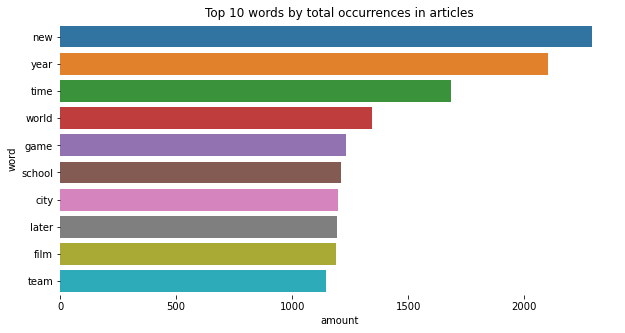

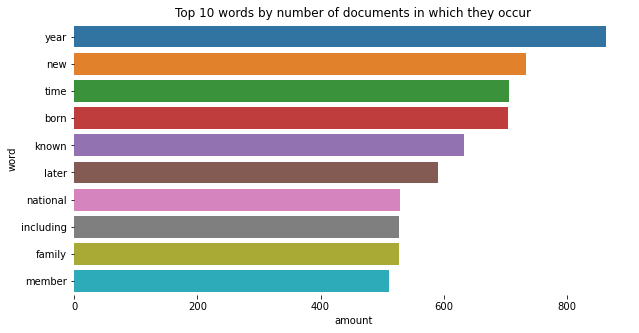

In [18]:
visualize_df = docs_df.copy(deep = True)
visualize_df.text = texts
visualize.visualize_most_frequent(visualize_df, 10)
visualize.visualize_most_frequent(visualize_df, 10, method="count")

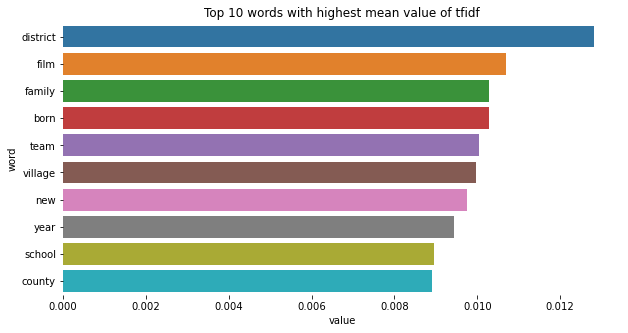

In [19]:
engine.compile_index(texts, docs_df.url.tolist())
visualize.visualize_tfidf(engine.index, 10)

In the case of random articles, it can be seen that there are few very specific words. These are very common words, right after the words excluded in stop words.

### Similarities

Let's start with the same articles as in previous case for example Berlin and Moscow

https://en.wikipedia.org/wiki/Novoivanovskoye                           0.168945
https://en.wikipedia.org/wiki/Metropolitan_regions_in_Germany           0.162176
https://en.wikipedia.org/wiki/3rd_Moscow_International_Film_Festival    0.125210
Name: _SCORE_TOTAL, dtype: float64


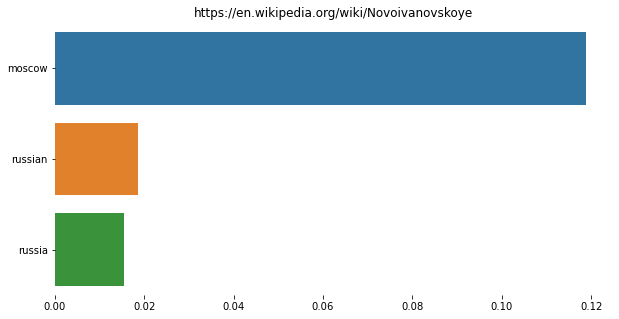

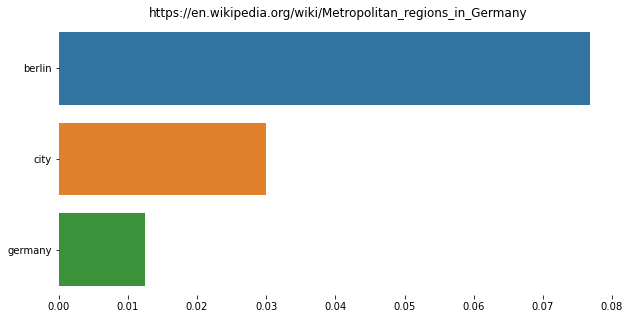

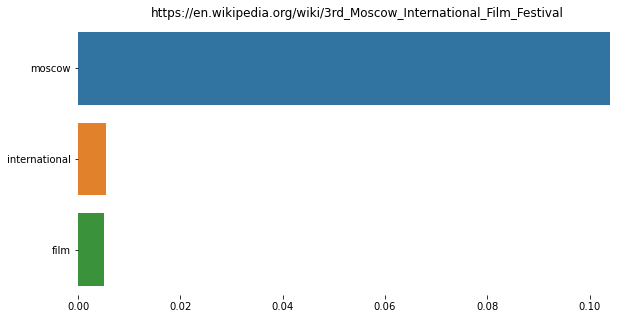

In [21]:
scores_df = engine.get_scores_dataframe_from_queries(capitals_queries, top_n=3)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 3)

It can be seen that the articles are much less closer to the topics than the previous time, there are few words by which to combine the articles and the results are related to the searched query.

https://en.wikipedia.org/wiki/Gentoo_penguin                   0.261477
https://en.wikipedia.org/wiki/Partula_taeniata                 0.127107
https://en.wikipedia.org/wiki/List_of_birds_of_Saint_Martin    0.115729
https://en.wikipedia.org/wiki/Leucascus                        0.112378
https://en.wikipedia.org/wiki/Calycobolus                      0.110163
Name: _SCORE_TOTAL, dtype: float64


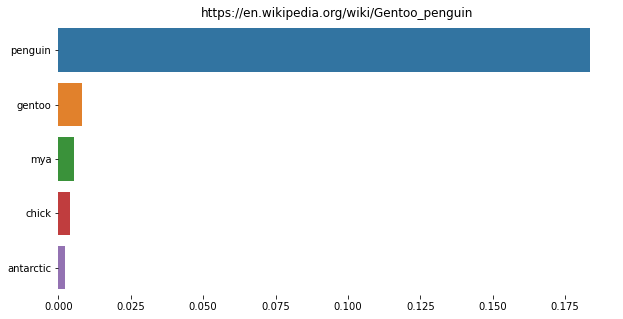

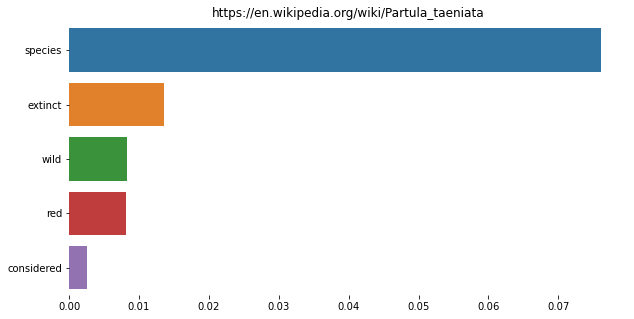

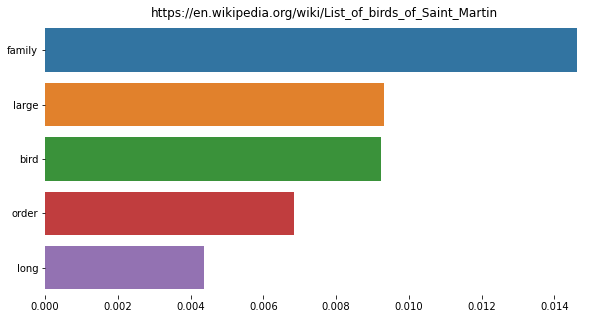

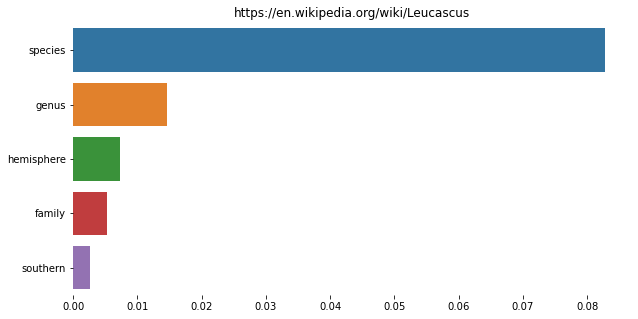

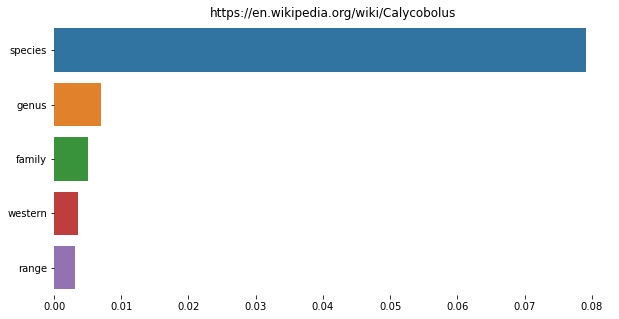

In [23]:
scores_df = engine.get_scores_dataframe_from_queries(animals_queries, top_n=5)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 5)

Again, while not getting articles directly related to our query, we are recommended articles from similar topic (animals).

### Conclusion
Random articles are worse in the sense of finding similar articles. This is due to a number of things:
-   Random articles are often very short
-   All pages are not very related to each other
-   A lot of words are not repeated
-   Articles are often very specific, often dedicated to different people

## 5. Space for your query

Below you can define settings and links for your query :)

In [25]:
FILENAME = "related_large_set_den.pq" # your file, you can generate your own or use either related_large_set_den.pq or unrelated_large_set.pq
THRESHOLD = 0 # be welcome to play around with the threshold
TOP_N = 5 # number of recomendations to receive

source_df = pd.read_parquet(FILENAME) 
engine.compile_index(texts, docs_df.url.tolist(), acceptance_threshold=THRESHOLD)

my_urls = ["https://en.wikipedia.org/wiki/Information_retrieval"] # provide your list of urls
my_queries = [search.wiki_page_from_url_to_content_text(url) for url in my_urls]

scores_df = engine.get_scores_dataframe_from_queries(my_queries, top_n=TOP_N)
print(scores_df.iloc[:, -1])

https://en.wikipedia.org/wiki/Text_(literary_theory)    0.150602
https://en.wikipedia.org/wiki/Religions_by_country      0.104651
https://en.wikipedia.org/wiki/Donna_R._Maglott          0.102093
https://en.wikipedia.org/wiki/Fltplan.com               0.101054
https://en.wikipedia.org/wiki/Raffi_Indjejikian         0.091160
Name: _SCORE_TOTAL, dtype: float64


You can also search for a raw text if you desire

In [29]:
text = "I would like to travel all over the European continent." # provide your query

scores_df = engine.get_scores_dataframe_from_query(text, top_n=TOP_N)
print(scores_df.iloc[:, -1])

https://en.wikipedia.org/wiki/New_Brunswick_Route_825                                                     0.115953
https://en.wikipedia.org/wiki/European_Track_Championships_%E2%80%93_Women's_under-23_points_race         0.111906
https://en.wikipedia.org/wiki/Methyltransferase_like_4                                                    0.105169
https://en.wikipedia.org/wiki/2005_European_Athletics_Indoor_Championships_%E2%80%93_Men's_1500_metres    0.098060
https://en.wikipedia.org/wiki/Kim_Bauermeister                                                            0.088043
Name: _SCORE_TOTAL, dtype: float64
